In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/pubg-finish-placement-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv")
test_df = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv")
sub = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv")

In [3]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df["winPlacePerc"] = imputer.fit_transform(train_df[["winPlacePerc"]])

In [5]:
sample_train_df= train_df.sample(frac=0.05, random_state=42)

In [6]:
sample_train_df["heal_boost"] = sample_train_df["heals"]+sample_train_df["boosts"]
sample_train_df["total_distance"] = sample_train_df["rideDistance"]+sample_train_df["swimDistance"]+sample_train_df["walkDistance"]
sample_train_df["find_zero_player"] = sample_train_df["rideDistance"]+sample_train_df["swimDistance"]+sample_train_df["walkDistance"]+sample_train_df["weaponsAcquired"]

In [34]:
sample_train_df.loc[sample_train_df["matchType"].str.contains("crash"), "matchType"] = "crash"
sample_train_df.loc[sample_train_df["matchType"].str.contains("flare"), "matchType"] = "flare"
sample_train_df.loc[sample_train_df["matchType"].str.contains("duo"), "matchType"] = "duo"
sample_train_df.loc[sample_train_df["matchType"].str.contains("solo"), "matchType"] = "solo"
sample_train_df.loc[sample_train_df["matchType"].str.contains("squad"), "matchType"] = "squad"

In [48]:
eda_df = sample_train_df[["heals","weaponsAcquired", "DBNOs","assists","damageDealt","vehicleDestroys","matchType", "winPlacePerc"]]

In [55]:
eda_df.loc[:, "perc"] = pd.cut(eda_df['winPlacePerc'], bins=10, labels=False)

In [56]:
group_eda_df = eda_df.groupby(["perc","matchType"])[["heals", "weaponsAcquired", "DBNOs","damageDealt", "assists", "vehicleDestroys"]].mean()

In [39]:
#group_eda_df.reset_index(inplace=True)

In [57]:
group_eda_df

heals  weaponsAcquired     DBNOs  damageDealt   assists  \
perc matchType                                                               
0    crash      0.090909         0.772727  0.272727    31.689773  0.000000   
     duo        0.019271         1.059899  0.191604    35.772858  0.035596   
     flare      0.096774         1.322581  0.451613    57.482581  0.064516   
     solo       0.011923         1.065467  0.000000    26.864706  0.033817   
     squad      0.066193         1.402215  0.313223    47.070359  0.064365   
1    crash      0.055556         1.277778  0.388889    55.659722  0.138889   
     duo        0.116696         1.876372  0.317302    59.012996  0.066869   
     flare      0.850000         2.850000  0.700000    90.982000  0.000000   
     solo       0.038827         1.551955  0.000000    39.280757  0.031844   
     squad      0.281406         2.358533  0.547110    76.163026  0.112424   
2    crash      0.256410         1.256410  0.282051    75.434615  0.051282   
     duo        0.310857         2.504280  0.395855    75.178825  0.081093   
     flare      0.750000         3.950000  0.700000    90.030000  0.100000   
     solo       0.158937         2.277432  0.000000    55.491520  0.035068   
     squad      0.535584         2.973851  0.653804    91.659371  0.152746   
3    crash      0.647059         1.764706  0.794118   105.896765  0.117647   
     duo        0.586217         3.115558  0.478182    93.214013  0.113602   
     flare      0.562500         4.312500  0.375000    37.720625  0.250000   
     solo       0.345854         3.015860  0.000000    73.283572  0.038954   
     squad      0.836990         3.466199  0.732522   103.397018  0.179710   
4    crash      0.892857         1.750000  0.357143    56.930000  0.035714   
     duo        0.856796         3.669192  0.511138   103.623121  0.132444   
     flare      2.900000         4.600000  1.000000   132.696000  0.100000   
     solo       0.593593         3.723677  0.000000    92.723331  0.044290   
     squad      1.267849         4.059786  0.782338   114.616543  0.215833   
5    crash      1.375000         1.937500  0.625000   105.869462  0.437500   
     duo        1.306108         4.235079  0.592321   118.937857  0.169808   
     flare      2.250000         5.416667  0.500000   120.824167  0.416667   
     solo       0.877660         4.307033  0.000000   114.878815  0.056738   
     squad      1.762697         4.526995  0.863956   129.027245  0.252881   
6    crash      3.175000         1.925000  0.600000    91.475250  0.325000   
     duo        1.835399         4.704373  0.665289   139.303664  0.227445   
     flare      3.153846         6.307692  0.538462    91.883846  0.000000   
     solo       1.125152         4.757613  0.000000   123.469630  0.057856   
     squad      2.231401         4.862149  0.962538   148.858085  0.331580   
7    crash      2.312500         1.843750  0.656250   124.263125  0.281250   
     duo        2.417485         5.077604  0.796329   167.193770  0.291096   
     flare      2.941176         5.941176  1.647059   214.124706  0.352941   
     solo       1.800514         5.114890  0.000000   151.878816  0.067734   
     squad      2.810580         5.075269  1.097734   170.589873  0.397465   
8    crash      2.525000         1.750000  0.725000   109.427100  0.225000   
     duo        2.986989         5.294090  0.976172   209.378217  0.391754   
     flare      4.500000         5.750000  1.187500   197.368750  0.375000   
     solo       2.471687         5.364364  0.000000   188.924339  0.092203   
     squad      3.079645         5.221565  1.307401   209.878172  0.523700   
9    crash      2.785714         1.785714  1.000000   240.051071  0.428571   
     duo        3.478108         5.544296  1.473569   335.751506  0.706985   
     flare      4.421053         8.000000  1.894737   389.883684  1.000000   
     solo       2.985067         5.626133  0.000000   317.849251  0.169333   
     squad      3.457413         5.408390

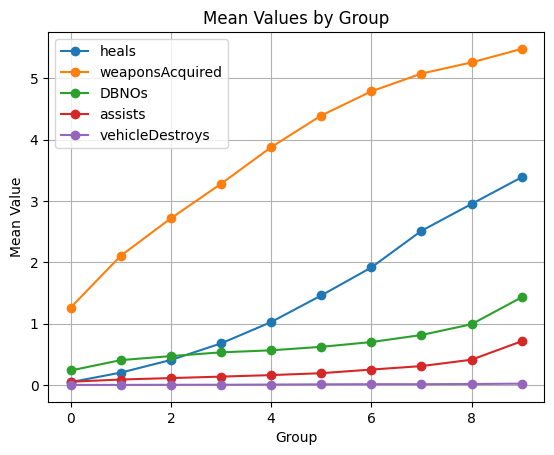

In [33]:
for column in group_eda_df.columns[1:]:
    plt.plot(group_eda_df['perc'], group_eda_df[column], marker='o', label=column)

# 그래프 설정
plt.title('Mean Values by Group')
plt.xlabel('Group')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
gruopby_eda_df

              heals                                         weaponsAcquired  \
matchType     crash       duo     flare      solo     squad           crash   
perc                                                                          
0          0.090909  0.019271  0.096774  0.011923  0.066193        0.772727   
1          0.055556  0.116696  0.850000  0.038827  0.281406        1.277778   
2          0.256410  0.310857  0.750000  0.158937  0.535584        1.256410   
3          0.647059  0.586217  0.562500  0.345854  0.836990        1.764706   
4          0.892857  0.856796  2.900000  0.593593  1.267849        1.750000   

                                                   ... damageDealt  \
matchType       duo     flare      solo     squad  ...       crash   
perc                                               ...               
0          1.059899  1.322581  1.065467  1.402215  ...   31.689773   
1          1.876372  2.850000  1.551955  2.358533  ...   55.659722   
2          2.5042

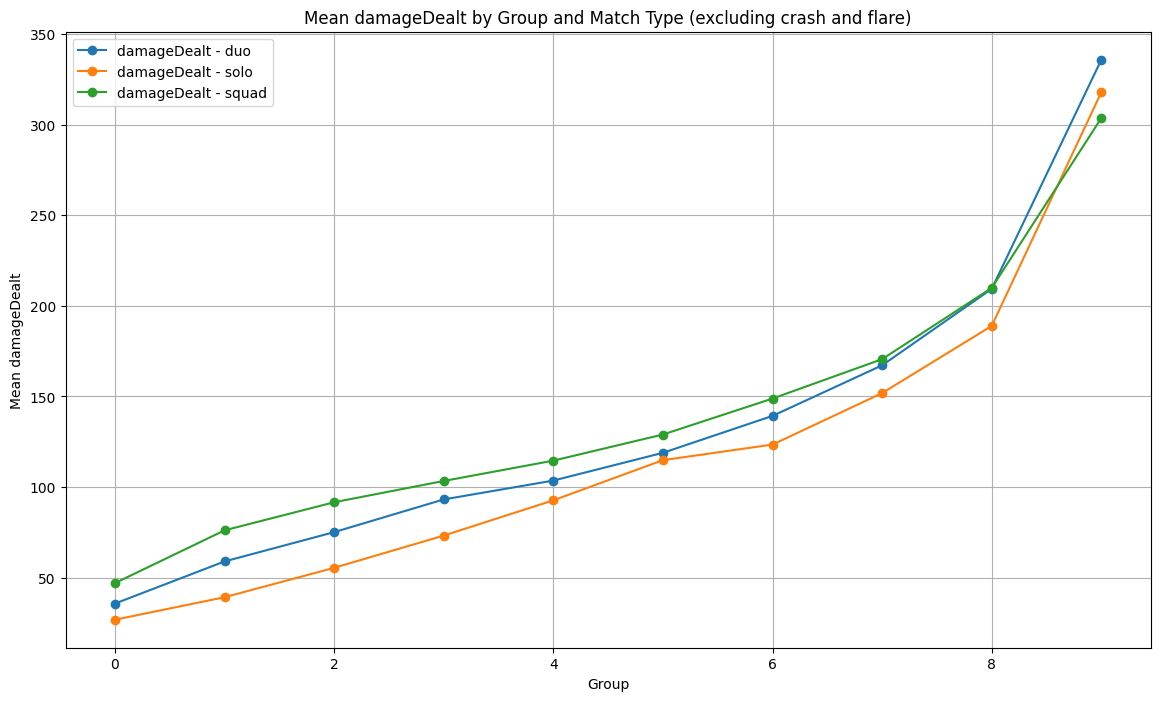

In [63]:


# 데이터 피벗팅
pivot_df = group_eda_df.pivot(index='perc', columns='matchType', values=['heals', 'weaponsAcquired', 'DBNOs', 'assists', 'damageDealt', 'vehicleDestroys'])

# 피벗된 데이터 확인
print(pivot_df.head())

# 제외할 matchType 목록
exclude_types = ['crash', 'flare']

# 그래프 그리기
plt.figure(figsize=(14, 8))

# 각 matchType에 대해 라인 차트를 그리기, 제외할 범주는 건너뜀
for match_type in pivot_df['damageDealt'].columns:
    if match_type not in exclude_types:
        plt.plot(pivot_df.index, pivot_df['damageDealt'][match_type], marker='o', label=f'damageDealt - {match_type}')

# 그래프 설정
plt.title('Mean damageDealt by Group and Match Type (excluding crash and flare)')
plt.xlabel('Group')
plt.ylabel('Mean damageDealt')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_df.head()

In [ ]:
train_df.columns

In [ ]:
features = ['assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace',  'kills',
       'killStreaks', 'longestKill', 'matchDuration',  'maxPlace',
       'numGroups', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired'] 
data_scaled = StandardScaler().fit_transform(train_df[features])


pca = PCA(n_components=5)
data_pca = pca.fit_transform(data_scaled)



In [ ]:
principalDf = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# 주성분 로딩 플롯 생성
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  
axs = axs.flatten()  

for i in range(5):
    axs[i].bar(features, loadings[:, i], color='skyblue')
    axs[i].set_title(f'PC{i+1} Loadings')
    axs[i].set_xticks(features)
    axs[i].set_xticklabels(features, rotation=90)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# 스캐터 플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(principalDf['PC1'], principalDf['PC2'])
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].set_title('Scatter Plot for PC1 vs PC2')
ax[0].grid(True)

ax[1].scatter(principalDf['PC3'], principalDf['PC4'])
ax[1].set_xlabel('Principal Component 3')
ax[1].set_ylabel('Principal Component 4')
ax[1].set_title('Scatter Plot for PC3 vs PC4')
ax[1].grid(True)

plt.show()

In [ ]:

loading_squared = loadings ** 2
feature_contribution = np.sum(loading_squared, axis=1) / np.sum(loading_squared)


feature_importance = pd.DataFrame(feature_contribution, index=features, columns=['Contribution'])
feature_importance = feature_importance.sort_values(by='Contribution', ascending=False)

print(feature_importance)

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=features)
print(loadings)

In [ ]:
variable_loadings = loadings.loc['assists']

# 로딩 값에 대한 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.bar(variable_loadings.index, variable_loadings.values, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Loading Value')
plt.title('Loading Values for "assists" across Principal Components')
plt.grid(True)
plt.show()

In [ ]:
top5 = train_df.loc[train_df["killPlace"]<=5]
middle = train_df.loc[(train_df["killPlace"]>5) & (train_df["killPlace"]<=25)]
lows = train_df.loc[train_df["killPlace"]>=25]

In [ ]:
top5_dsc = top5.describe()
m_dsc= middle.describe()
l_dsc = lows.describe()

In [ ]:
print(top5_dsc.loc['mean']/m_dsc.loc['mean'])

In [ ]:
l_dsc.round(2)

In [ ]:
m_dsc

In [23]:
data = train_df[["kills", "killPlace","damageDealt",  "boosts", "winPlacePerc"]].copy()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data)


data['cluster'] = kmeans.labels_
# 각 클러스터에서 동일 비율 추출하여 45k 레코드 
sample_data = data.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=0.01))  

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_33/2594482418.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_data = data.groupby('cluster', group_keys=False).apply(lambda x: x.sample(frac=0.01))


In [35]:
sample_data[sample_data["cluster"]==4].count()

kills           410
killPlace       410
damageDealt     410
boosts          410
winPlacePerc    410
cluster         410
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

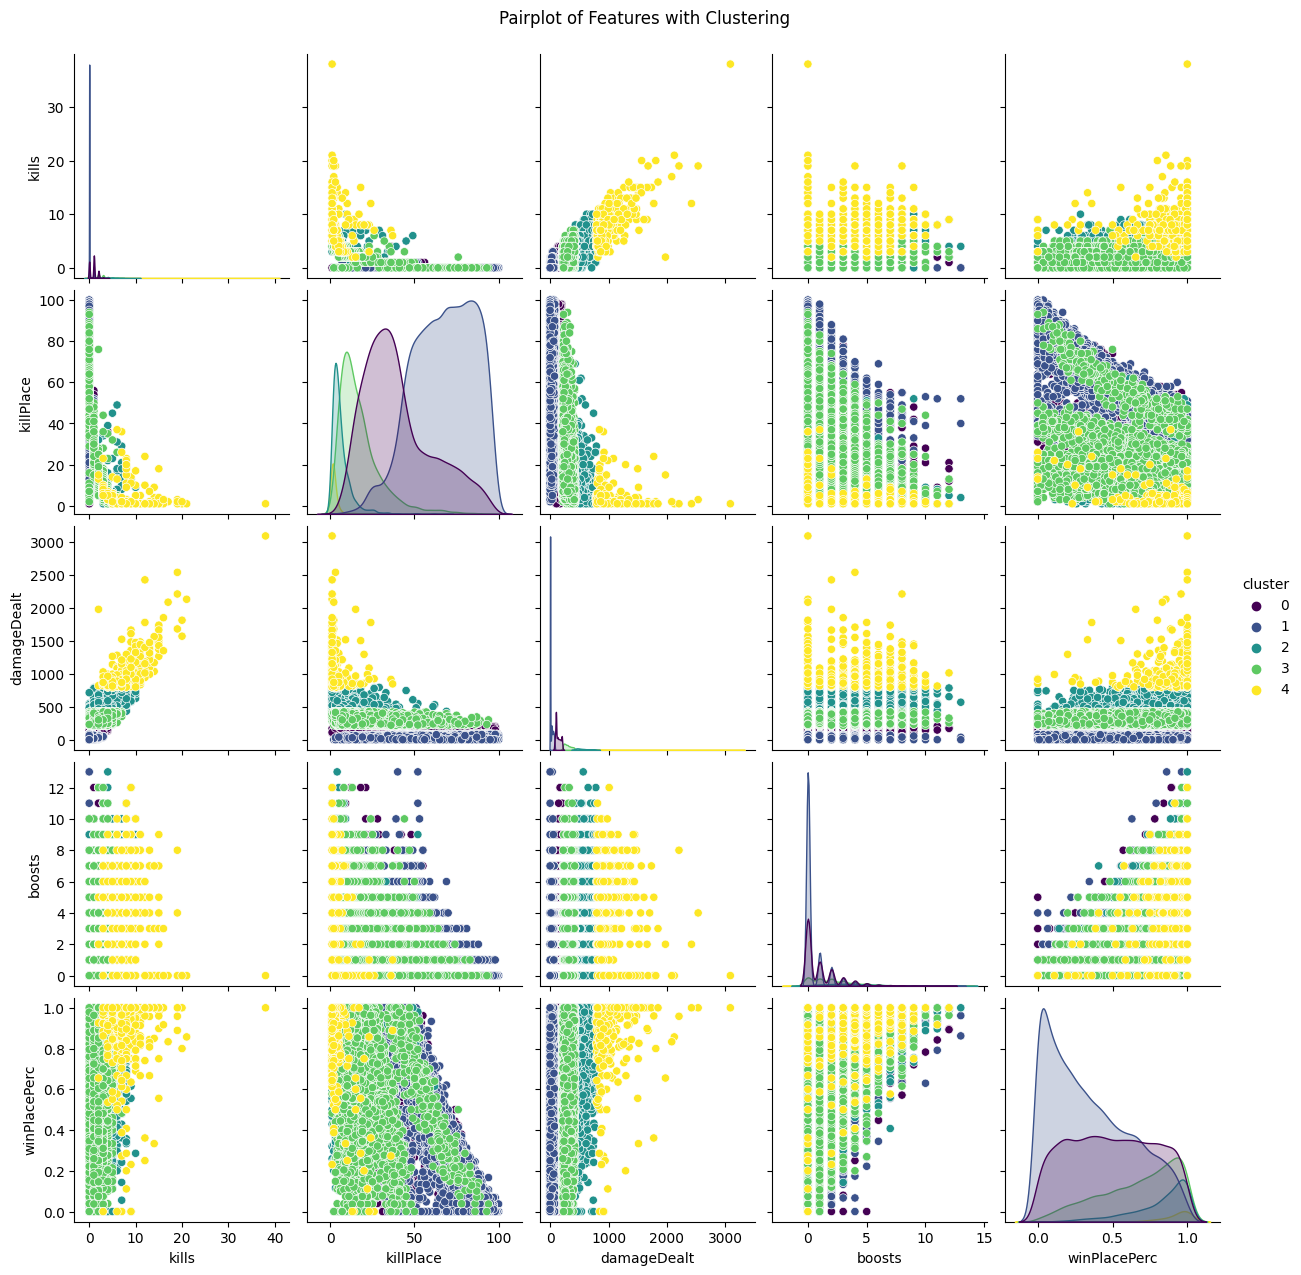

In [24]:

sns.pairplot(sample_data, hue='cluster', palette='viridis')
plt.suptitle('Pairplot of Features with Clustering', y=1.02)  
plt.show()

In [28]:
squad = train_df.loc[train_df["matchType"].str.contains("squad")]

In [29]:
squad

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.0,5,0,0.6400
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.7,3,0,0.1667
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00,1,1,0,44,...,0,0.0000,0,0.000,0,0,34.7,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.00,0,0,0,96,...,0,0.0000,0,0.000,0,0,13.5,1,1497,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446956,dae05e0d743059,3902915a7a1943,97b64a07c05761,1,0,151.90,0,0,1,77,...,1,0.0000,0,0.000,0,0,828.3,7,0,0.1071
4446960,69fa4c2d5431b1,2a3ad0e37fb6ce,818ccf2160343f,0,0,327.70,3,2,0,4,...,0,180.4000,0,0.000,0,0,845.6,3,0,0.2414
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.0,3,1507,0.1786
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.7,4,0,0.4815


In [30]:
tops = squad["winPlacePerc"].quantile(0.99)

In [31]:
squad_tops = squad[squad["winPlacePerc"]>=tops]

In [33]:
squad_tops.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,...,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.000000,90631.0
mean,1.187243,3.564255,375.934153,2.217133,0.829076,3.384261,13.920138,586.296676,3.228763,1.288091,...,0.528859,1484.772282,0.006355,9.898774,0.010648,0.030177,2996.479859,5.612848,644.997484,1.0
std,1.256371,2.237502,311.815271,2.304628,1.309710,3.579398,13.749687,709.654796,2.981165,0.852940,...,0.792539,2272.696944,0.091474,45.451117,0.117569,0.182437,978.182138,2.636242,764.931854,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,2.000000,153.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2523.000000,4.000000,0.000000,1.0
50%,1.000000,3.000000,308.500000,2.000000,0.000000,2.000000,9.000000,0.000000,3.000000,1.000000,...,0.000000,0.005800,0.000000,0.000000,0.000000,0.000000,3045.000000,5.000000,0.000000,1.0
75%,2.000000,5.000000,521.000000,3.000000,1.000000,5.000000,21.000000,1351.000000,5.000000,2.000000,...,1.000000,2393.000000,0.000000,0.000000,0.000000,0.000000,3538.000000,7.000000,1513.000000,1.0
max,15.000000,19.000000,5990.000000,53.000000,64.000000,54.000000,72.000000,2140.000000,72.000000,20.000000,...,10.000000,17610.000000,4.000000,3823.000000,12.000000,4.000000,13430.000000,85.000000,2013.000000,1.0


In [49]:
squad_tops["killPlace"] = squad_tops["killPlace"].astype(int) 

/tmp/ipykernel_33/3683513617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  squad_tops["killPlace"] = squad_tops["killPlace"].astype(int)


In [50]:
squad_tops["killPlace"].dtype

dtype('int64')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x1000 with 0 Axes>

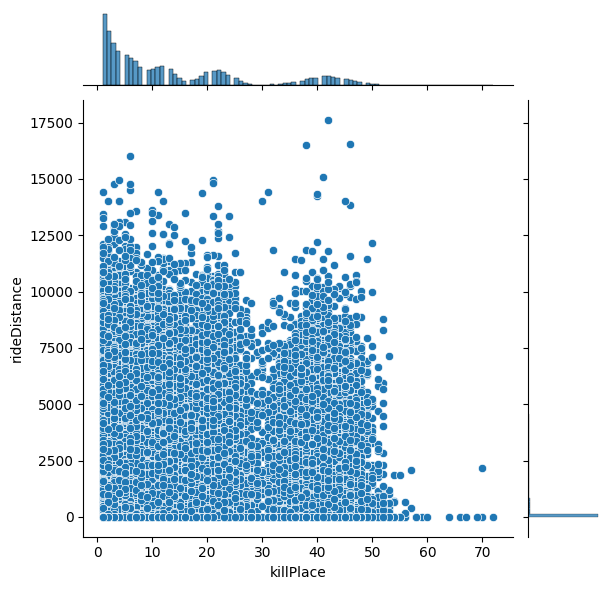

In [60]:
plt.figure(figsize=(10,10))
sns.jointplot(data=squad_tops, x="killPlace", y="rideDistance", kind="scatter")
plt.show()